In [1]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt

from numpy import pi, sin, cos, exp, sqrt, log, log10, random, angle, matlib  
#import basic functions from numpy that we'll need
from numpy.fft import fft, ifft

In [2]:
from google.colab import files # if you use google.colab
uploaded = files.upload()

Saving sampleEEGdata.mat to sampleEEGdata.mat


In [3]:
# utils

def nextpow2(i):
    n = 1
    while n < i: n *= 2
    return n

def closest(X, p):
    disp = X - p
    return np.argmin((disp*disp))

In [89]:
data = scipy.io.loadmat('sampleEEGdata')
EEGdata = data["EEG"][0,0]["data"]
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
EEGtrials = data["EEG"][0,0]["trials"][0,0]

EEGchanlocslabels=data["EEG"][0,0]["chanlocs"][0]["labels"]

## Task 1

In [ ]:

chan2use = ["Fz", "F7", "P7"]

min_freq = 3
max_freq = 30
num_frex = 20

freqs2use  = np.logspace(log10(min_freq),log10(max_freq),num_frex)
times2save = np.arange(-400,800,20)
timewindow = np.linspace(1.5,3,len(freqs2use))
baselinetm = [-400 -200]

# define convolution parameters
time = np.arange(-1,1+1/EEGsrate,1/EEGsrate)
n_wavelet  = len(time)
n_data     = EEGpnts*EEGtrials
num_cycles = np.logspace(log10(4),log10(8),len(freqs2use))
n_convolution = n_wavelet + n_data - 1
n_conv_pow2   = nextpow2(n_convolution)
half_of_wavelet_size = (n_wavelet)//2

# time in indices
times2saveidx = [closest(EEGtimes,x) for x in times2save]
baseidx       = [closest(times2save,x) for x in [-500,-200]]

#initialize
itps = np.zeros([len(chan2use), len(freqs2use),len(times2save)]) #frequencies x time steps
pwr  = np.zeros([len(chan2use), len(freqs2use),len(times2save)])

# fft data
selectedChannel = EEGchanlocslabels  == chan2use[0]
data_fft1          = fft(np.reshape(EEGdata[selectedChannel,:,:],[EEGpnts*EEGtrials],order="F"),n_conv_pow2)
selectedChannel = EEGchanlocslabels  == chan2use[1]
data_fft2          = fft(np.reshape(EEGdata[selectedChannel,:,:],[EEGpnts*EEGtrials],order="F"),n_conv_pow2)
selectedChannel = EEGchanlocslabels  == chan2use[2]
data_fft3          = fft(np.reshape(EEGdata[selectedChannel,:,:],[EEGpnts*EEGtrials],order="F"),n_conv_pow2)


for fi in range(len(freqs2use)):
    
    # wavelet
    s = num_cycles[fi]/(2*pi*freqs2use[fi]) # standard deviation for wavelet
    fft_wavelet = fft(exp(2*pi*1j*freqs2use[fi]*time) * exp(-time**2/(2*s**2)),n_conv_pow2) #multiple complex sinewave by gaussian to make morlet wavelet

    # phase data1
    eegconv = ifft(fft_wavelet*data_fft1) #convolution theorem
    eegconv = eegconv[:n_convolution]
    eegconv = eegconv[half_of_wavelet_size:-half_of_wavelet_size]
    eegconv = np.reshape(eegconv,[EEGpnts,EEGtrials],order="F")
    phase_sig1 = np.angle(eegconv)
    #real_sig1 = np.real(eegconv)
    itps[0,fi,:] = np.abs(np.mean(exp(1j*phase_sig1[times2saveidx,:]),1))
    pwr[0,fi,:] =  np.mean(eegconv[times2saveidx,:]*np.conj(eegconv[times2saveidx,:]),axis = 1) 
    
    # phase data2
    eegconv = ifft(fft_wavelet*data_fft2) #convolution theorem
    eegconv = eegconv[:n_convolution]
    eegconv = eegconv[half_of_wavelet_size:-half_of_wavelet_size]
    eegconv = np.reshape(eegconv,[EEGpnts,EEGtrials],order="F")
    phase_sig2 = np.angle(eegconv)
    #real_sig2 = np.real(eegconv)
    itps[1,fi,:] = np.abs(np.mean(exp(1j*phase_sig2[times2saveidx,:]),1))
    pwr[1,fi,:] =  np.mean(eegconv[times2saveidx,:]*np.conj(eegconv[times2saveidx,:]),axis = 1) 
    
    # phase data3
    eegconv = ifft(fft_wavelet*data_fft3) #convolution theorem
    eegconv = eegconv[:n_convolution]
    eegconv = eegconv[half_of_wavelet_size:-half_of_wavelet_size]
    eegconv = np.reshape(eegconv,[EEGpnts,EEGtrials],order="F")
    phase_sig3 = np.angle(eegconv)
   # real_sig3 = np.real(eegconv)
    itps[2,fi,:] = np.abs(np.mean(exp(1j*phase_sig3[times2saveidx,:]),1))
    pwr[2,fi,:] =  np.mean(eegconv[times2saveidx,:]*np.conj(eegconv[times2saveidx,:]),axis = 1) 
    
  

In [33]:
pwr[0,fi, baseidx]

array([3.34141656, 3.19786654])

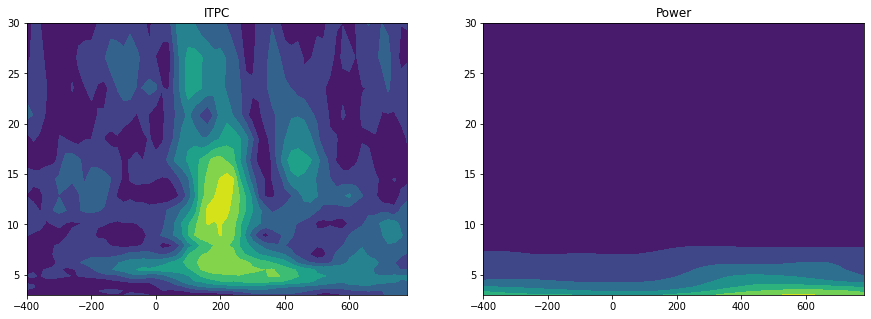

In [43]:
plt.figure(figsize=[15,5] )
plt.subplot(121)
plt.contourf(times2save,freqs2use, itps[0,:,:],);
plt.title('ITPC')

plt.subplot(122);
plt.contourf(times2save,freqs2use, pwr[0,:,:],);
plt.title('Power');


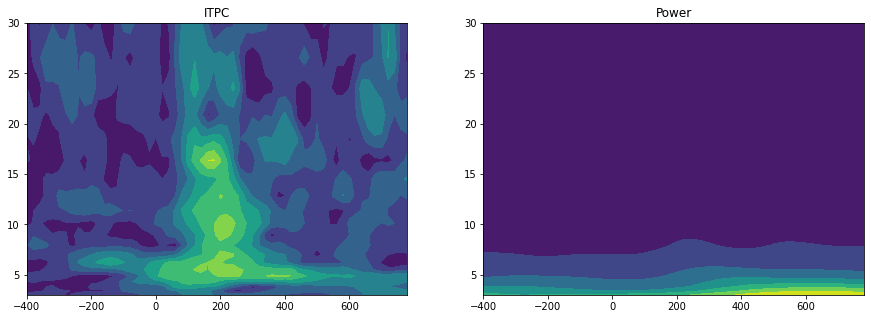

In [42]:
plt.figure(figsize=[15,5] )
plt.subplot(121)
plt.contourf(times2save,freqs2use, itps[1,:,:],);
plt.title('ITPC')

plt.subplot(122);
plt.contourf(times2save,freqs2use, pwr[1,:,:],);
plt.title('Power');


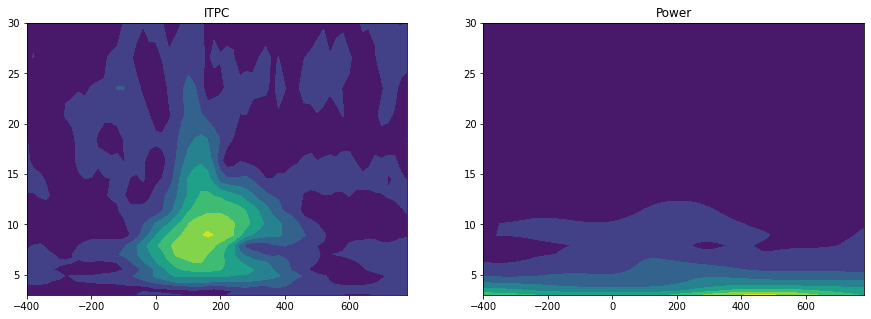

In [41]:
plt.figure(figsize=[15,5] )
plt.subplot(121)
plt.contourf(times2save,freqs2use, itps[2,:,:],);
plt.title('ITPC')

plt.subplot(122);
plt.contourf(times2save,freqs2use, pwr[2,:,:],);
plt.title('Power');


- The results of ITPC and power are generally similar for Fz and F7 electrodes, and tehre is some difference in power between P7 and other electrodes
- The results of ITPC patterns are generally different from the power patterns

## Task 2

In [90]:
seedChannel = EEGchanlocslabels  == 'Fz'
otherChannels = EEGchanlocslabels  != 'Fz'

In [91]:
seedChannel

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [96]:
chan2compare = [i for i in EEGchanlocslabels if "Fz" != i ]
chan2compare[:5]

[array(['Fp1'], dtype='<U3'),
 array(['AF7'], dtype='<U3'),
 array(['AF3'], dtype='<U3'),
 array(['F1'], dtype='<U2'),
 array(['F3'], dtype='<U2')]

In [142]:
freqs2use  = 10
times2save = np.arange(300,350,5)
timewindow = np.linspace(1.5,3,1)
baselinetm = [-400 -200]

# define convolution parameters
time = np.arange(-1,1+1/EEGsrate,1/EEGsrate)
n_wavelet  = len(time)
n_data     = EEGpnts*EEGtrials
num_cycles = 4
n_convolution = n_wavelet + n_data - 1
n_conv_pow2   = nextpow2(n_convolution)
half_of_wavelet_size = (n_wavelet)//2

# time in indices
times2saveidx = [closest(EEGtimes,x) for x in times2save]
baseidx       = [closest(times2save,x) for x in [-500,-200]]

#initialize
itps = np.zeros([1, 1, len(times2save)]) #frequencies x time steps
pwr  = np.zeros([1, 1, len(times2save)])

selectedChannel = EEGchanlocslabels  == 'Fz'
data_fft          = fft(np.reshape(EEGdata[selectedChannel,:,:],[EEGpnts*EEGtrials],order="F"),n_conv_pow2)

s = num_cycles/(2*pi*freqs2use) # standard deviation for wavelet
fft_wavelet = fft(exp(2*pi*1j*freqs2use*time) * exp(-time**2/(2*s**2)),n_conv_pow2)

In [143]:
eegconv = ifft(fft_wavelet*data_fft) #convolution theorem
eegconv = eegconv[:n_convolution]
eegconv = eegconv[half_of_wavelet_size:-half_of_wavelet_size]
eegconv = np.reshape(eegconv,[EEGpnts,EEGtrials],order="F")
phase_sig_seed = np.angle(eegconv)

In [144]:
phase_sig_seed.shape

(640, 99)

In [145]:
pli_channels = np.zeros([63, len(times2save)])
ispc_channels = np.zeros([63, len(times2save)])

for idx, ch in enumerate(chan2compare):
    selectedChannel = EEGchanlocslabels  == ch
    data_fft2         = fft(np.reshape(EEGdata[selectedChannel,:,:],[EEGpnts*EEGtrials],order="F"),n_conv_pow2)
    
     # phase data2
    eegconv = ifft(fft_wavelet*data_fft2) #convolution theorem
    eegconv = eegconv[:n_convolution]
    eegconv = eegconv[half_of_wavelet_size:-half_of_wavelet_size]
    eegconv = np.reshape(eegconv,[EEGpnts,EEGtrials],order="F")
    phase_sig2 = np.angle(eegconv)
    # phase angle differences
    phase_diffs = phase_sig_seed-phase_sig2  # time vector: time points x trials
    phases = phase_diffs[times2saveidx,:]
    pli  = np.abs(np.mean(np.sign(np.imag(exp(1j*phases))),1))
    ispc = np.abs(np.mean(exp(1j*phases), 1))  
    
    # compute time window in indices for this frequency
    #time_window_idx = int(np.round((1000/freqs2use)*timewindow[0]/(1000/EEGsrate)));
    pli_channels[idx,:] = pli
    ispc_channels[idx,:] = ispc


In [146]:
pli_channels.shape

(63, 10)

In [147]:
times2save

array([300, 305, 310, 315, 320, 325, 330, 335, 340, 345])

In [148]:
!pip install mne

In [149]:
tmp = [i[0] for i in EEGchanlocslabels[otherChannels]]

In [151]:
times2save

array([300, 305, 310, 315, 320, 325, 330, 335, 340, 345])

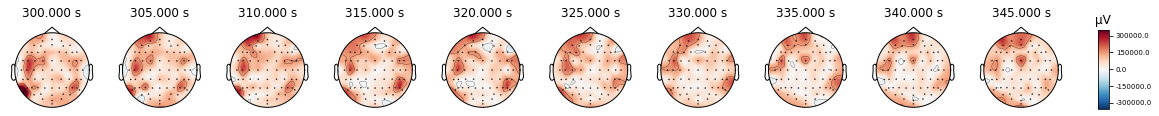

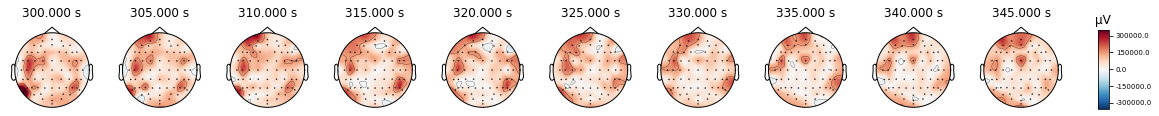

In [152]:
import mne

biosemi_montage = mne.channels.make_standard_montage('biosemi64')
n_channels = len(biosemi_montage.ch_names)
fake_info = mne.create_info(ch_names=tmp, sfreq=250.,
                            ch_types='eeg')

rng = np.random.RandomState(0)
data_fake = rng.normal(size=(n_channels, 1)) * 1e-6

data_mne = mne.EvokedArray(pli_channels, fake_info)
data_mne.times = times2save
data_mne.data = pli_channels
data_mne.set_montage(biosemi_montage)

times2plot = times2save
times2plot

data_mne.plot_topomap(times2plot, ch_type='eeg', time_unit='s')

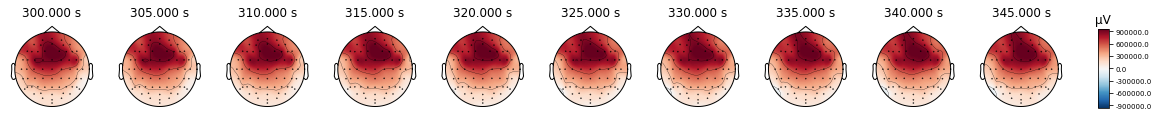

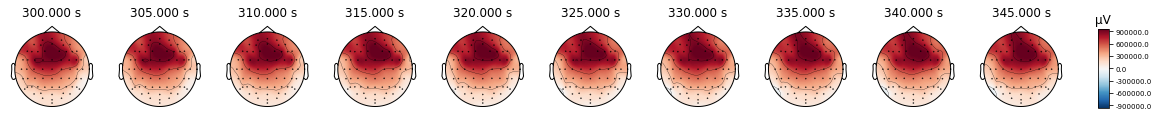

In [153]:
biosemi_montage = mne.channels.make_standard_montage('biosemi64')
n_channels = len(biosemi_montage.ch_names)
fake_info = mne.create_info(ch_names=tmp, sfreq=250.,
                            ch_types='eeg')

rng = np.random.RandomState(0)
data_fake = rng.normal(size=(n_channels, 1)) * 1e-6

data_mne = mne.EvokedArray(ispc_channels, fake_info)
data_mne.times = times2save
data_mne.data = ispc_channels
data_mne.set_montage(biosemi_montage)

times2plot = times2save
times2plot

data_mne.plot_topomap(times2plot, ch_type='eeg', time_unit='s')

- For the ispc results, the connectivity between Fz and frontal regions is higher
- For the PLI results, there is additional connectivity between Fz and left temporal region and the magnitude is lower